# Notebook on usage of OWL ViT

- OWL-ViT (short for Vision Transformer for Open-World Localization)

- OWL-ViT is an open-vocabulary object detection network trained on a variety of (image, text) pairs. It can be used to query an image with one or multiple text queries to search for and detect target objects described in text.

- Being open-vocabulary object detector, OWL-ViT is not restricted to detecting the set of classes from training data. Instead, it can detect objects in image based on free-text quaries without the need to fine-tune the model on labeled datasets.

- OWL-ViT leverages multi-modal representations to perform open-vocabulary detection. It combines CLIP with lightweight object classification and localization heads. Open-vocabulary detection is achieved by embedding free-text queries with the text encoder of CLIP and using them as input to the object classification and localization heads. associate images and their corresponding textual descriptions, and ViT processes image patches as inputs. The authors of OWL-ViT first trained CLIP from scratch and then fine-tuned OWL-ViT end to end on standard object detection datasets using a bipartite matching loss.

![image-2.png](https://lh3.googleusercontent.com/d/1Ve0_UoFis1UIjoKFaA0iHQzat7F60gTV)

OWL-ViT architecture. Taken from the original paper.

# References
- https://huggingface.co/docs/transformers/tasks/zero_shot_object_detection
- https://huggingface.co/docs/transformers/en/model_doc/owlvit
- https://huggingface.co/docs/transformers/en/model_doc/owlv2
- https://huggingface.co/google/owlv2-base-patch16-ensemble

# Zero-shot object detection pipeline

## With hugging face pipeline api
The simplest way to try out inference with OWL-ViT is to use it in a pipeline(). This would abstract away most of the complex code and boiler plate from the library, offering a simple APi dedicated to tasks.

In [ ]:
from transformers import pipeline

checkpoint = "google/owlvit-base-patch32" #google/owlv2-base-patch16-ensemble
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


Select an image that you would like to detect object in. Here, we'll use image of astronaut that is part of the NASA image dataset

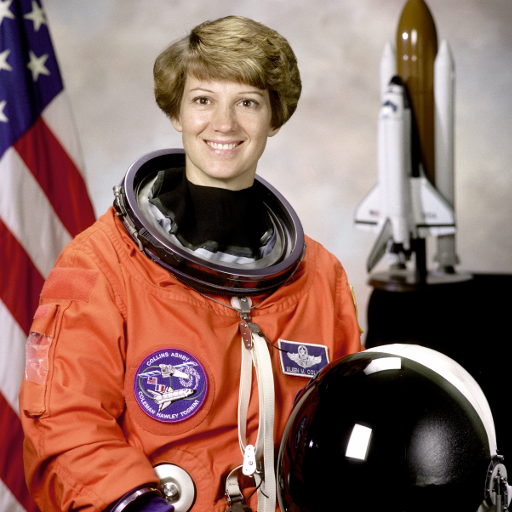

In [ ]:
import skimage
import numpy as np
from PIL import Image

image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")
image

Since the pipeline for "detector" is prepared, we would only need to pass the image directly and also text description for all the items that is to be queried.

In [ ]:
predictions = detector(
    image,
    candidate_labels=["face", "rocket", "nasa badge", "star-spangled banner"],
)
predictions

[{'score': 0.28099697828292847,
  'label': 'nasa badge',
  'box': {'xmin': 129, 'ymin': 348, 'xmax': 206, 'ymax': 427}},
 {'score': 0.21102380752563477,
  'label': 'rocket',
  'box': {'xmin': 350, 'ymin': -1, 'xmax': 468, 'ymax': 288}},
 {'score': 0.13790462911128998,
  'label': 'star-spangled banner',
  'box': {'xmin': 1, 'ymin': 1, 'xmax': 105, 'ymax': 509}},
 {'score': 0.11950109899044037,
  'label': 'nasa badge',
  'box': {'xmin': 277, 'ymin': 338, 'xmax': 327, 'ymax': 380}},
 {'score': 0.10649354010820389,
  'label': 'rocket',
  'box': {'xmin': 358, 'ymin': 64, 'xmax': 424, 'ymax': 280}}]

Illustrating the predictions

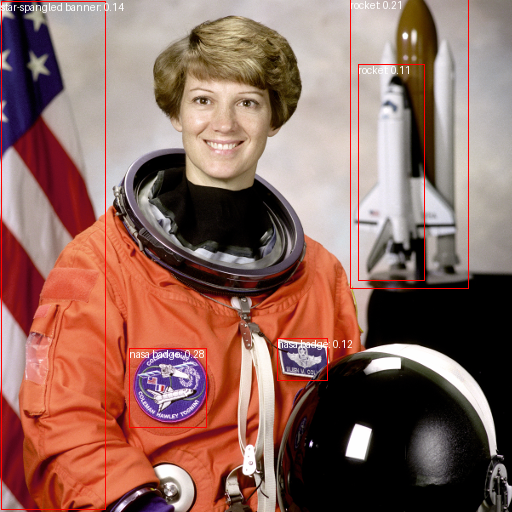

In [ ]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

## Manual Zero-shot object detection
Alternatively, manually using the model, processor and transfomers functions to achieve the same pipeline, but with more control and flexibility. This is required for more custimized pipelines.

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

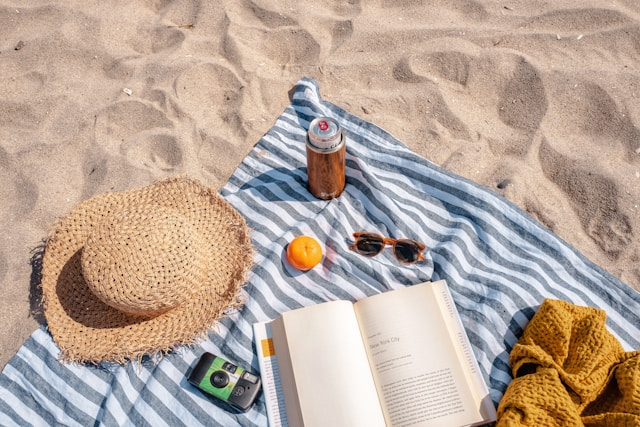

In [ ]:
import requests

# image prompts
url = "https://unsplash.com/photos/oj0zeY2Ltk4/download?ixid=MnwxMjA3fDB8MXxzZWFyY2h8MTR8fHBpY25pY3xlbnwwfHx8fDE2Nzc0OTE1NDk&force=true&w=640"
im = Image.open(requests.get(url, stream=True).raw)

# text prompts
text_queries = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_queries, images=im, return_tensors="pt")

# printing the image
im

In [ ]:
import torch

with torch.no_grad():
    outputs = model(**inputs)
    target_sizes = torch.tensor([im.size[::-1]])
    results = processor.post_process_object_detection(outputs, threshold=0.1, target_sizes=target_sizes)[0]


Query:sunglasses 0.26
	 349.7604675292969 228.73757934570312 430.01202392578125 265.03253173828125
Query:hat 0.11
	 39.39917755126953 173.2859649658203 260.11968994140625 363.5246887207031
Query:book 0.19
	 270.1138610839844 284.132568359375 502.33380126953125 427.4662780761719


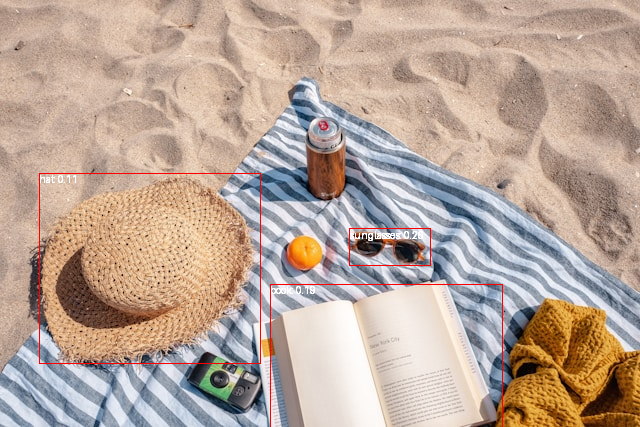

In [ ]:
draw = ImageDraw.Draw(im)

scores = results["scores"].tolist()
labels = results["labels"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_queries[label]}: {round(score,2)}", fill="white")
    print('Query:'+ text_queries[label], round(score,2))
    print(f"\t {' '.join(str(i) for i in [xmin, ymin, xmax, ymax])}")

im

## Image-guided object detection
**Using image to find its presense in another image**

In addition to zero-shot object detection with text queries, OWL-ViT offers image-guided object detection. This means
you can use an image query to find similar objects in the target image.
Unlike text queries, only a single example image is allowed.

Let's take an image with two cats on a couch as a target image, and an image of a single cat
as a query:

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

Text(0.5, 1.0, 'Query Image')

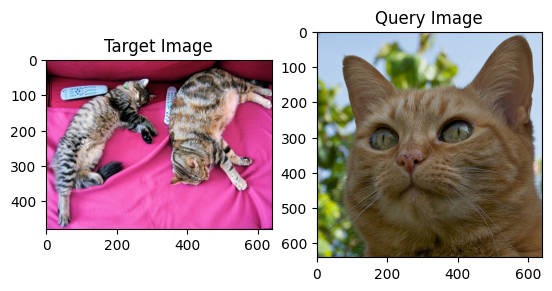

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[0].set_title("Target Image")
ax[1].imshow(query_image)
ax[1].set_title("Query Image")

In [ ]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

For predictions, instead of passing the inputs to the model, pass them to [image_guided_detection()](https://huggingface.co/docs/transformers/main/en/model_doc/owlvit#transformers.OwlViTForObjectDetection.image_guided_detection). Draw the predictions
as before except now there are no labels.

[1.0596466064453125, 8.406543731689453, 638.8873901367188, 151.43310546875]
[72.81147003173828, 77.65863037109375, 114.66329956054688, 103.08651733398438]
[14.900169372558594, 58.90711975097656, 324.77764892578125, 324.7627868652344]


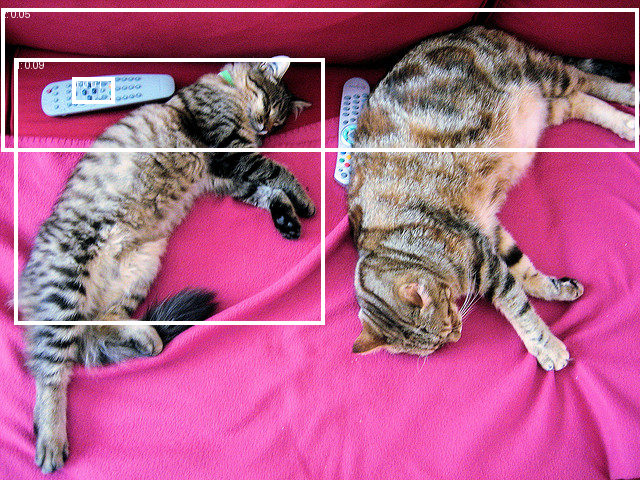

In [ ]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score, label in zip(boxes, scores, labels):
    xmin, ymin, xmax, ymax = box
    print(box)
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image_target